In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from glob2 import glob

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")

ImportError: cannot import name 'croston_classic' from 'statsforecast.models' (/Users/chai/miniforge3/envs/d-env/lib/python3.10/site-packages/statsforecast/models.py)

In [ ]:
data_list = glob('./aT_data/data/train/*.csv')
epoch = 1000
batch = 64
tr_del_list = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 '] # train 에서 사용하지 않는 열
ts_del_list = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)'] # test 에서 사용하지 않는 열
check_col = ['일자구분_중순', '일자구분_초순', '일자구분_하순','월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', 
             '월구분_4월','월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'] # 열 개수 맞추기

  0%|          | 0/37 [00:00<?, ?it/s]/Users/chai/miniforge3/envs/darts-env/lib/python3.9/site-packages/darts/timeseries.py:4039: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
  0%|          | 0/37 [00:00<?, ?it/s]
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  func(*args, **kwargs)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  func(*args, **kwargs)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Gl

1


/Users/chai/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chai/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/User

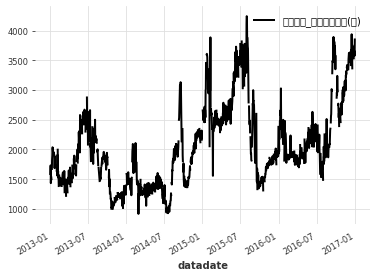

In [ ]:
for i in tqdm(data_list):
    df_number = i.split("_")[-1].split(".")[0]
    df = pd.read_csv(i)
    df['datadate'] = pd.to_datetime(df['datadate'], format = '%Y%m%d')
    df.replace(' ', np.nan)
    
    series = TimeSeries.from_dataframe(df, time_col = 'datadate', value_cols = ['해당일자_전체평균가격(원)'], fill_missing_dates=True)
    series.plot()
    break


In [30]:
df = df.replace('nan', np.nan)
df['단가(원)'][0]

nan

In [18]:
# series = TimeSeries.from_dataframe(series)

ValueError: could not convert string to float: ''

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datadate         1461 non-null   int64  
 1   단가(원)            1224 non-null   float64
 2   거래량              1224 non-null   float64
 3   거래대금(원)          1224 non-null   float64
 4   경매건수             1224 non-null   float64
 5   도매시장코드           1224 non-null   float64
 6   도매법인코드           1224 non-null   float64
 7   산지코드             1224 non-null   float64
 8   해당일자_전체평균가격(원)   1224 non-null   float64
 9   해당일자_전체거래물량(kg)  1224 non-null   float64
 10  하위가격 평균가(원)      1220 non-null   float64
 11  상위가격 평균가(원)      1221 non-null   float64
 12  하위가격 거래물량(kg)    1220 non-null   float64
 13  상위가격 거래물량(kg)    1221 non-null   float64
 14  일자별_도매가격_최대(원)   948 non-null    float64
 15  일자별_도매가격_평균(원)   948 non-null    float64
 16  일자별_도매가격_최소(원)   948 non-null    float64
 17  일자별_소매가격_최대(원)